# How and Why BatchNorm Works - Part 2


In Part 1, we showed that batch normalization (BN) can help train neural networks by reducing internal covariate shift (ICS) and smoothing gradient updates. ICS was defined in terms of activation distributions by Ioffe and Szegedy (2015). For our fully-connected network, we indeed observed that the activation distributions for the network with BN were comparatively stable compared to those for the network without BN.
We also touched upon the idea that BN has a smoothing effect on the loss function making it more convex (residual connections have a similar effect).

In their 2018 paper, Santukar et al. used a new definition of ICS and argued that BN has no substantial effect on it. In fact, BN improves training performance even when random noise is added to the activations to force covariate shift.  They argue that the major reason for improved performance loss surface smoothing.

Santurkar et. al define internal covariate shift (ICS) of activation i at time t to be the difference $||Gt,i − G′ t,i||^2$, where
$$
G_{t,i} = ∇W^{(t)}_i L(W (t) 1 , . . . , W (t) k ; x(t), y(t)) G′ t,i = ∇W (t) i L(W (t+1) 1 , . . . , W (t+1) i−1 , W (t) i , W (t) i+1, . . . , W (t) k ; x(t), y(t)).
$$

This is more of an *operational* definition that measures the impact on the gradient of a particular layer due covariate shift. In simple terms, if updating the previous layers changes the activations for the current layer significantly, it should impact the gradient of the current layer significantly as well.


In this experiment, we will start by reproducing the results from Santukar et al. Then we will try and understand why their results and our previous experiment differ.

In [1]:
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    !git clone https://github.com/novastar53/deepkit
    !cd deepkit && git checkout santurkar-ics && git pull && uv build . --wheel && pip uninstall deepkit -y && pip install ./dist/* --quiet
else:
    import sys
    from pathlib import Path
    package_path = Path("../../deepkit/src").resolve()
    if str(package_path) not in sys.path:
        sys.path.append(str(package_path))




## Let's set up the model
We'll be using the standard VGG-Net architecture as per the paper.






In [2]:
import jax
import jax.numpy as jnp
import flax.nnx as nnx

kernel_init = nnx.initializers.glorot_normal()


class VGGBlock(nnx.Module):
    def __init__(self, in_features: int, out_features: int, rngs: nnx.Rngs):
        self.conv = nnx.Conv(in_features=in_features,
                             out_features=out_features,
                             kernel_size=(3, 3),
                             kernel_init=kernel_init,
                             padding='SAME',
                             rngs=rngs)
        self.bn = nnx.BatchNorm(num_features=out_features, momentum=0.90, rngs=rngs)

    def __call__(self, x):
        x = self.conv(x)
        conv_activation = x
        x = self.bn(x)
        x = nnx.relu(x)
        return x, conv_activation

class VGGNet(nnx.Module):
    def __init__(self, rngs: nnx.Rngs):
        self.convs = [
            VGGBlock(in_features=3, out_features=64,  rngs=rngs),
            VGGBlock(in_features=64, out_features=64,  rngs=rngs),

            VGGBlock(in_features=64, out_features=128, rngs=rngs),
            VGGBlock(in_features=128, out_features=128, rngs=rngs),

            VGGBlock(in_features=128, out_features=256, rngs=rngs),
            VGGBlock(in_features=256, out_features=256, rngs=rngs),

            VGGBlock(in_features=256, out_features=512, rngs=rngs),
            VGGBlock(in_features=512, out_features=512, rngs=rngs),

            VGGBlock(in_features=512, out_features=512, rngs=rngs),
            VGGBlock(in_features=512, out_features=512, rngs=rngs),
        ]

        self.fc1 = nnx.Linear(in_features=512, out_features=96, kernel_init=kernel_init, rngs=rngs)
        self.fc2 = nnx.Linear(in_features=96, out_features=96, kernel_init=kernel_init, rngs=rngs)
        self.out = nnx.Linear(in_features=96, out_features=10,  kernel_init=kernel_init, rngs=rngs)

    def __call__(self, x):
        activations = {}
        max_pool_after = [1, 3, 5, 7, 9]
        for conv_idx in range(len(self.convs)):
            layer = self.convs[conv_idx]
            x, act = layer(x)
            activations[f"conv_{conv_idx}"] = act
            if conv_idx in max_pool_after:
                x = nnx.max_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = x.squeeze()

        x = self.fc1(x)
        activations["fc1"] = x
        x = nnx.relu(x)

        x = self.fc2(x)
        activations["fc2"] = x
        x = nnx.relu(x)

        x = self.out(x)
        activations["out"] = x
        return x, activations

In [3]:
rng_key = jax.random.key(42)
rngs = nnx.Rngs(rng_key)
candidate = VGGNet(rngs=rngs)
graphdef, state = nnx.split(candidate)
param_counts = sum(jax.tree_util.tree_leaves(jax.tree_util.tree_map(lambda x: x.size, state)))
print(f"Initialized model with {param_counts:,} parameters.")
nnx.display(state)

Initialized model with 9,476,298 parameters.


In [4]:
rng_key = jax.random.key(42)
rngs = nnx.Rngs(rng_key)
baseline = VGGNet(rngs=rngs)

class Dummy(nnx.Module):
    def __call__(self, x):
        return x

# Remove the batchnorm layers
for vgg in baseline.convs:
  vgg.bn = lambda x: x
graphdef, state = nnx.split(baseline)
param_counts = sum(jax.tree_util.tree_leaves(jax.tree_util.tree_map(lambda x: x.size, state)))
print(f"Initialized model with {param_counts:,} parameters.")
nnx.display(state)

Initialized model with 9,464,522 parameters.


In [5]:
import optax

lr = 0.03
momentum = 0.9


baseline_optimizer = nnx.Optimizer(baseline, optax.sgd(learning_rate=lr, momentum=momentum, nesterov=False))
candidate_optimizer = nnx.Optimizer(candidate, optax.sgd(learning_rate=lr, momentum=momentum, nesterov=False))


In [6]:
import copy
from functools import partial


def loss_fn(model, batch, targets):
    logits, activations = model(batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, targets).mean()
    return loss, activations

@nnx.jit
def step_fn(model: nnx.Module, optimizer: nnx.Optimizer, batch: jax.Array, labels: jax.Array):
    (loss, activations), grads = nnx.value_and_grad(loss_fn, has_aux=True)(model, batch, labels)
    optimizer.update(grads)
    return loss, activations, grads


@nnx.jit
def accuracy(model: nnx.Module, batch: jax.Array, labels: jax.Array):
    logits, _ = model(batch)
    #probs = nnx.softmax(logits, axis=-1)
    preds = jnp.argmax(logits, axis=-1)
    sum = jnp.sum(preds == labels)
    acc = sum/logits.shape[0]
    return acc


def test_accuracy(model: nnx.Module, testloader):
    acc, n = 0, 0
    for batch, labels in testloader:
        batch = jnp.array(batch)
        labels = jnp.array(labels)
        acc += accuracy(model, batch, labels)
        n += 1
    return acc/n



In [7]:
from deepkit.datasets import load_CIFAR10
from deepkit.loggers import DiskLogger


num_epochs = 39

train_loader, test_loader = load_CIFAR10(augment=False)
num_steps = num_epochs*len(train_loader)


# Ioffe et. al Style ICS Measure

In [ ]:
i = 0
baseline_train_accs, candidate_train_accs = [], []
baseline_test_accs, candidate_test_accs = [], []
baseline_train_losses, candidate_train_losses = [], []
baseline_activations_logger = DiskLogger("baseline_activations")
candidate_activations_logger = DiskLogger("candidate_activations")

: 

In [ ]:
import time

from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
from IPython.display import clear_output

%matplotlib inline

try:
  for epoch in range(num_epochs):
      for batch, labels in train_loader:
          batch = jnp.array(batch)
          labels = jnp.array(labels)
          baseline.train()
          candidate.train()
          baseline_loss, baseline_activations, baseline_grads = step_fn(baseline, baseline_optimizer, batch, labels)
          candidate_loss, candidate_activations, candidate_grads = step_fn(candidate, candidate_optimizer, batch, labels)
          baseline_train_losses.append(baseline_loss)
          candidate_train_losses.append(candidate_loss)
          baseline.eval()
          candidate.eval()
          baseline_acc = accuracy(baseline, batch, labels)
          candidate_acc = accuracy(candidate, batch, labels)
          baseline_train_accs.append(baseline_acc)
          candidate_train_accs.append(candidate_acc)
          if i % 200 == 0:
            baseline_test_acc = test_accuracy(baseline, test_loader)
            candidate_test_acc = test_accuracy(candidate, test_loader)
            baseline_test_accs.append(baseline_test_acc)
            candidate_test_accs.append(candidate_test_acc)
            baseline_activations_logger.log(i, baseline_activations)
            candidate_activations_logger.log(i, candidate_activations)
          if i % 20 == 0:
            clear_output(wait=True)
            print(f"iter: {i} | baseline loss: {baseline_loss:0.4f} | candidate loss: {candidate_loss:0.4f} | baseline train acc: {baseline_acc:0.2f} | candidate train acc: {candidate_acc:0.2f} | baseline test acc: {baseline_test_acc: 0.2f} | candidate test acc: {candidate_test_acc: 0.2f}")
            fig, axes = plt.subplots(1, 3, figsize=(15, 4))
            axes[0].plot(baseline_train_losses, alpha=0.9, label="Without BatchNorm")
            axes[0].plot(candidate_train_losses, alpha=0.5, label="With BatchNorm")
            axes[0].set_title("Loss")
            axes[1].plot(baseline_train_accs, alpha=0.9, label="Without BatchNorm")
            axes[1].plot(candidate_train_accs, alpha=0.5, label="With BatchNorm")
            axes[1].set_title("Train Accuracy")
            axes[2].plot(baseline_test_accs, label="Without Batchnorm")
            axes[2].plot(candidate_test_accs, label="With Batchnorm")
            axes[2].set_title("Test Accuracy")
            plt.legend()
            plt.show()

          #print(f"iter: {i} | baseline test acc: {baseline_test_acc: 0.2f} | candidate test acc: {candidate_test_acc: 0.2f}")
          i += 1
except KeyboardInterrupt:
    print("Received KeyboardInterrupt. Exiting...")

Received KeyboardInterrupt. Exiting...


: 

In [ ]:
from matplotlib import colormaps as cm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

layers = [f"conv_{i}" for i in range(10)] + ["fc1", "fc2", "out"]

fig, axs = plt.subplots(13, 1, figsize=(5,24), constrained_layout=True)


def update(frame):
    baseline_activations = baseline_activations_logger[frame]
    candidate_activations = candidate_activations_logger[frame]
    for layer_idx, layer in enumerate(layers):
        axs[layer_idx].cla()
        layer_baseline_activations = baseline_activations[layer].flatten()
        layer_baseline_mean = layer_baseline_activations.mean()
        layer_baseline_std = layer_baseline_activations.std()
        axs[layer_idx].hist(layer_baseline_activations, color=cm["Blues"](50), bins=60, alpha=1.0)

        layer_candidate_activations = candidate_activations[layer].flatten()
        layer_candidate_mean = layer_candidate_activations.mean()
        layer_candidate_std = layer_candidate_activations.std()
        axs[layer_idx].hist(layer_candidate_activations, color=cm["Reds"](90),  bins=60, alpha=0.5)
        axs[layer_idx].set_title(f"{layer} Outputs - Iteration:{frame}")

        axs[layer_idx].margins(x=0, y=0)
        axs[layer_idx].set_xlim(-8, 8)
        axs[layer_idx].legend([f"Baseline: {layer_baseline_mean:0.2f} ± {layer_baseline_std:0.2f}",
                              f"Candidate:{layer_candidate_mean:0.2f} ± {layer_candidate_std:0.2f}"])


ani = FuncAnimation(fig, update, frames=len(baseline_activations_logger), interval=300, repeat=True)
plt.close(fig)
video_html = ani.to_html5_video().replace('<video', '<video muted')
HTML(video_html)

NameError: name 'plt' is not defined

: 

# Santurkar et. al Implementation of Internal Covariate Shift


In [ ]:
baseline_train_accs, candidate_train_accs = [], []
baseline_test_accs, candidate_test_accs = [], []
baseline_train_losses, candidate_train_losses = [], []
baseline_ics_results, candidate_ics_results = [], []
i = 0

iter: 20 | baseline loss: 2.3002 | candidate loss: 1.6817 | baseline train acc: 0.12 | candidate train acc: 0.28 | baseline test acc:  0.10 | candidate test acc:  0.10


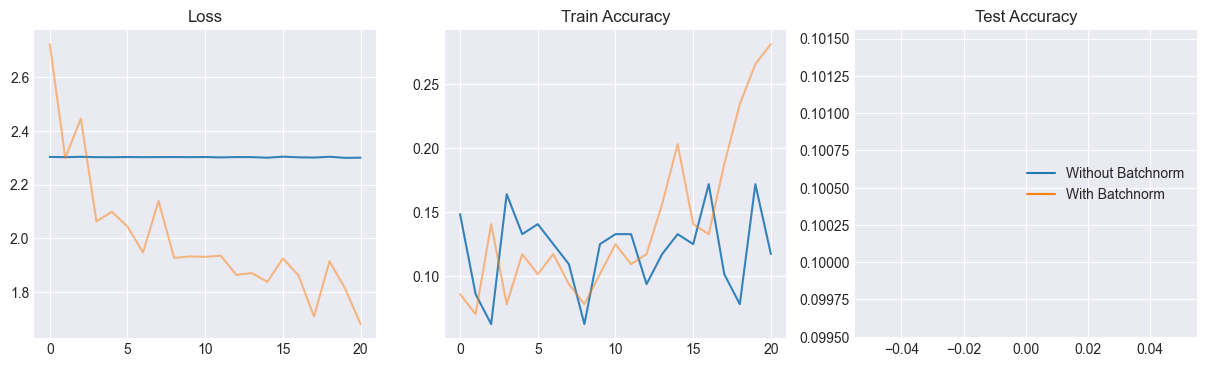

Received KeyboardInterrupt. Exiting...


In [ ]:
import time

from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
from IPython.display import clear_output

from deepkit.internal_covariate_shift import santurkar_ics_step

%matplotlib inline


baseline.train()
candidate.train()



try:
  for epoch in range(num_epochs):
      for batch, labels in train_loader:
          batch = jnp.array(batch)
          labels = jnp.array(labels)

          baseline_optimizer_copy = baseline_optimizer.__deepcopy__()
          baseline.train()
          baseline_loss, baseline_activations, baseline_grads = step_fn(baseline, baseline_optimizer, batch, labels)
          baseline_optimizer_copy.model.eval()
          baseline_ics_measures = santurkar_ics_step(baseline_optimizer_copy,
                                           baseline_grads,
                                           batch,
                                           labels)
          baseline_ics_results.append(baseline_ics_measures)


          candidate_optimizer_copy = candidate_optimizer.__deepcopy__()
          candidate.train()
          candidate_loss, candidate_activations, candidate_grads = step_fn(candidate, candidate_optimizer, batch, labels)
          candidate_optimizer_copy.model.eval()
          candidate_ics_measures = santurkar_ics_step(candidate_optimizer_copy,
                                           candidate_grads,
                                           batch,
                                           labels)
          candidate_ics_results.append(candidate_ics_measures)

          baseline_train_losses.append(baseline_loss)
          candidate_train_losses.append(candidate_loss)
          baseline.eval()
          candidate.eval()
          baseline_acc = accuracy(baseline, batch, labels)
          candidate_acc = accuracy(candidate, batch, labels)
          baseline_train_accs.append(baseline_acc)
          candidate_train_accs.append(candidate_acc)
          if i % 200 == 0:
            baseline_test_acc = test_accuracy(baseline, test_loader)
            candidate_test_acc = test_accuracy(candidate, test_loader)
            baseline_test_accs.append(baseline_test_acc)
            candidate_test_accs.append(candidate_test_acc)
          if i % 20 == 0:
            clear_output(wait=True)
            print(f"iter: {i} | baseline loss: {baseline_loss:0.4f} | candidate loss: {candidate_loss:0.4f} | baseline train acc: {baseline_acc:0.2f} | candidate train acc: {candidate_acc:0.2f} | baseline test acc: {baseline_test_acc: 0.2f} | candidate test acc: {candidate_test_acc: 0.2f}")
            fig, axes = plt.subplots(1, 3, figsize=(15, 4))
            axes[0].plot(baseline_train_losses, alpha=0.9, label="Without BatchNorm")
            axes[0].plot(candidate_train_losses, alpha=0.5, label="With BatchNorm")
            axes[0].set_title("Loss")
            axes[1].plot(baseline_train_accs, alpha=0.9, label="Without BatchNorm")
            axes[1].plot(candidate_train_accs, alpha=0.5, label="With BatchNorm")
            axes[1].set_title("Train Accuracy")
            axes[2].plot(baseline_test_accs, label="Without Batchnorm")
            axes[2].plot(candidate_test_accs, label="With Batchnorm")
            axes[2].set_title("Test Accuracy")
            plt.legend()
            plt.show()

          #print(f"iter: {i} | baseline test acc: {baseline_test_acc: 0.2f} | candidate test acc: {candidate_test_acc: 0.2f}")
          i += 1
except KeyboardInterrupt:
    print("Received KeyboardInterrupt. Exiting...")


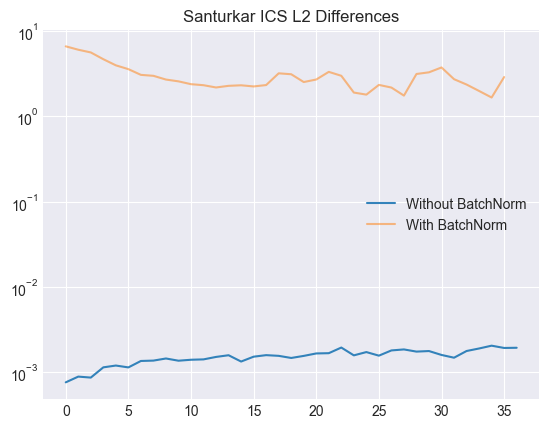

In [ ]:
conv_layer_id = 5

baseline_kernel_ics_l2_norms = [ n[conv_layer_id][0].conv.kernel.value for n in baseline_ics_results ]
candidate_kernel_ics_l2_norms = [ n[conv_layer_id][0].conv.kernel.value for n in candidate_ics_results ]

plt.plot(baseline_kernel_ics_l2_norms, label="Without BatchNorm", alpha=0.9)
plt.plot(candidate_kernel_ics_l2_norms, label="With BatchNorm", alpha=0.5)
plt.yscale('log')
plt.title("Santurkar ICS L2 Differences")
plt.legend()
plt.show()

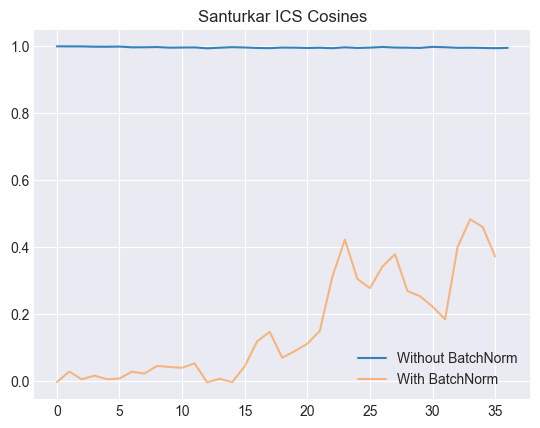

In [ ]:
baseline_kernel_ics_cosines =  [ n[conv_layer_id][1].conv.kernel.value for n in baseline_ics_results ]
candidate_kernel_ics_cosines = [ n[conv_layer_id][1].conv.kernel.value for n in candidate_ics_results ]

plt.plot(baseline_kernel_ics_cosines, label="Without BatchNorm", alpha=0.9)
plt.plot(candidate_kernel_ics_cosines, label="With BatchNorm", alpha=0.5)
plt.title("Santurkar ICS Cosines")
plt.legend()
plt.show()

# Loss Landscape

In [15]:
baseline_train_accs, candidate_train_accs = [], []
baseline_test_accs, candidate_test_accs = [], []
baseline_train_losses, candidate_train_losses = [], []
baseline_loss_landscape_ranges, candidate_loss_landscape_ranges = [], []
i = 0

In [16]:
import time

from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
from IPython.display import clear_output

from deepkit.internal_covariate_shift import loss_landscape_step

%matplotlib inline


try:
  for epoch in range(num_epochs):
      for batch, labels in train_loader:
          batch = jnp.array(batch)
          labels = jnp.array(labels)

          baseline.train()
          baseline_loss, baseline_activations, baseline_grads = (
               step_fn(baseline, baseline_optimizer, batch, labels)
          )
          baseline_copy = baseline.__deepcopy__()
          baseline_copy.eval()
          baseline_loss_range = (
              loss_landscape_step(baseline_copy,
                                  batch,
                                  labels,
                                  baseline_grads,
                                  max_step=40,
                                  step_size=1,
                                  lr=lr
             )
          )
          baseline_loss_landscape_ranges.append(baseline_loss_range)

          candidate.train()
          candidate_loss, candidate_activations, candidate_grads = (
              step_fn(candidate, candidate_optimizer, batch, labels)
          )
          candidate_copy = candidate.__deepcopy__()
          candidate_copy.eval()
          candidate_loss_range = (
            loss_landscape_step(candidate,
                                batch,
                                labels,
                                candidate_grads,
                                max_step=40,
                                step_size=1,
                                lr=lr
             )
          )
          candidate_loss_landscape_ranges.append(candidate_loss_range)

          baseline_train_losses.append(baseline_loss)
          candidate_train_losses.append(candidate_loss)

          baseline.eval()
          candidate.eval()
          baseline_acc = accuracy(baseline, batch, labels)
          candidate_acc = accuracy(candidate, batch, labels)
          baseline_train_accs.append(baseline_acc)
          candidate_train_accs.append(candidate_acc)
          if i % 200 == 0:
            baseline_test_acc = test_accuracy(baseline, test_loader)
            candidate_test_acc = test_accuracy(candidate, test_loader)
            baseline_test_accs.append(baseline_test_acc)
            candidate_test_accs.append(candidate_test_acc)
          if i % 20 == 0:
            clear_output(wait=True)
            print(f"iter: {i} | baseline loss: {baseline_loss:0.4f} | "
                  f"candidate loss: {candidate_loss:0.4f} | "
                  f"baseline train acc: {baseline_acc:0.2f} | "
                  f"candidate train acc: {candidate_acc:0.2f} | "
                  f"baseline test acc: {baseline_test_acc: 0.2f} | "
                  f"candidate test acc: {candidate_test_acc: 0.2f}")
            fig, axes = plt.subplots(1, 3, figsize=(15, 4))
            axes[0].plot(baseline_train_losses, alpha=0.9,
                         label="Without BatchNorm")
            axes[0].plot(candidate_train_losses, alpha=0.5,
                         label="With BatchNorm")
            axes[0].set_title("Loss")
            axes[1].plot(baseline_train_accs, alpha=0.9,
                         label="Without BatchNorm")
            axes[1].plot(candidate_train_accs, alpha=0.5,
                         label="With BatchNorm")
            axes[1].set_title("Train Accuracy")
            axes[2].plot(baseline_test_accs, label="Without Batchnorm")
            axes[2].plot(candidate_test_accs, label="With Batchnorm")
            axes[2].set_title("Test Accuracy")
            plt.legend()
            plt.show()

          i += 1
except KeyboardInterrupt:
    print("Received KeyboardInterrupt. Exiting...")


Received KeyboardInterrupt. Exiting...


15141


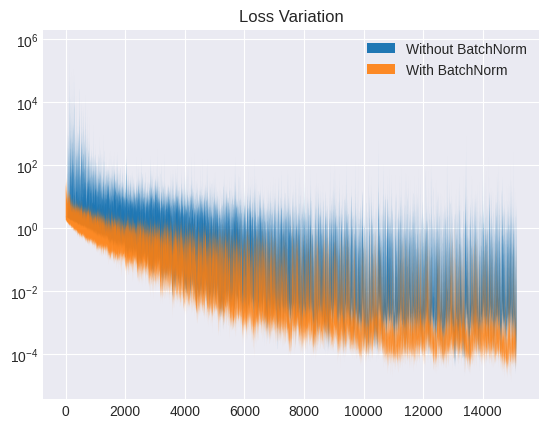

In [ ]:
print(len(baseline_loss_landscape_ranges))
baseline_min_vals = [ s[0] for s in baseline_loss_landscape_ranges ]
baseline_max_vals = [ s[1] for s in baseline_loss_landscape_ranges ]
baseline_x_vals = list(range(len(baseline_min_vals)))

plt.fill_between(baseline_x_vals, baseline_min_vals, baseline_max_vals, alpha=1.0, label="Without BatchNorm")

candidate_min_vals = [ s[0] for s in candidate_loss_landscape_ranges ]
candidate_max_vals = [ s[1] for s in candidate_loss_landscape_ranges ]
candidate_x_vals = list(range(len(candidate_min_vals)))

plt.fill_between(candidate_x_vals, candidate_min_vals, candidate_max_vals, alpha=0.9, label="With BatchNorm")

plt.yscale("log")
plt.legend()
plt.title("Loss Variation")
plt.show()

# Gradient Predictiveness



In [8]:
baseline_train_accs, candidate_train_accs = [], []
baseline_test_accs, candidate_test_accs = [], []
baseline_train_losses, candidate_train_losses = [], []
baseline_grad_landscape_ranges, candidate_grad_landscape_ranges = [], []
i = 0

iter: 60 | baseline loss: 2.3407 | candidate loss: 1.7446 | baseline train acc: 0.08 | candidate train acc: 0.31 | baseline test acc:  0.10 | candidate test acc:  0.10


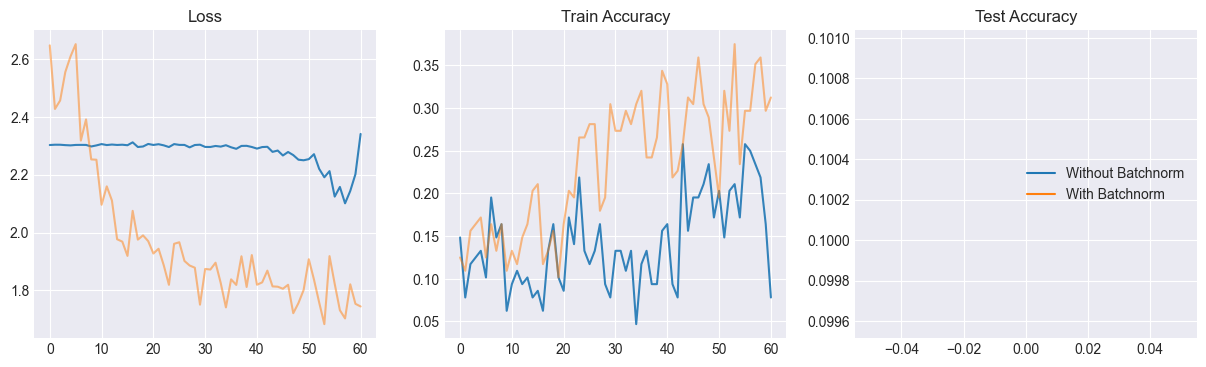

Received KeyboardInterrupt. Exiting...


In [12]:
import time

from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
from IPython.display import clear_output

from deepkit.internal_covariate_shift import grad_landscape_step

%matplotlib inline


try:
  for epoch in range(num_epochs):
      for batch, labels in train_loader:
          batch = jnp.array(batch)
          labels = jnp.array(labels)

          baseline.train()
          baseline_loss, baseline_activations, baseline_grads = (
               step_fn(baseline, baseline_optimizer, batch, labels)
          )
          baseline_copy = baseline.__deepcopy__()
          baseline_copy.eval()
          baseline_grad_range = (
              grad_landscape_step(baseline_copy,
                                  batch,
                                  labels,
                                  baseline_grads,
                                  max_step=40,
                                  step_size=5,
                                  lr=lr
             )
          )
          baseline_grad_landscape_ranges.append(baseline_grad_range)

          candidate.train()
          candidate_loss, candidate_activations, candidate_grads = (
              step_fn(candidate, candidate_optimizer, batch, labels)
          )
          candidate_copy = candidate.__deepcopy__()
          candidate_copy.eval()
          candidate_grad_range = (
            grad_landscape_step(candidate,
                                batch,
                                labels,
                                candidate_grads,
                                max_step=40,
                                step_size=5,
                                lr=lr
             )
          )
          candidate_grad_landscape_ranges.append(candidate_grad_range)

          baseline_train_losses.append(baseline_loss)
          candidate_train_losses.append(candidate_loss)

          baseline.eval()
          candidate.eval()
          baseline_acc = accuracy(baseline, batch, labels)
          candidate_acc = accuracy(candidate, batch, labels)
          baseline_train_accs.append(baseline_acc)
          candidate_train_accs.append(candidate_acc)
          if i % 200 == 0:
            baseline_test_acc = test_accuracy(baseline, test_loader)
            candidate_test_acc = test_accuracy(candidate, test_loader)
            baseline_test_accs.append(baseline_test_acc)
            candidate_test_accs.append(candidate_test_acc)
          if i % 20 == 0:
            clear_output(wait=True)
            print(f"iter: {i} | baseline loss: {baseline_loss:0.4f} | "
                  f"candidate loss: {candidate_loss:0.4f} | "
                  f"baseline train acc: {baseline_acc:0.2f} | "
                  f"candidate train acc: {candidate_acc:0.2f} | "
                  f"baseline test acc: {baseline_test_acc: 0.2f} | "
                  f"candidate test acc: {candidate_test_acc: 0.2f}")
            fig, axes = plt.subplots(1, 3, figsize=(15, 4))
            axes[0].plot(baseline_train_losses, alpha=0.9,
                         label="Without BatchNorm")
            axes[0].plot(candidate_train_losses, alpha=0.5,
                         label="With BatchNorm")
            axes[0].set_title("Loss")
            axes[1].plot(baseline_train_accs, alpha=0.9,
                         label="Without BatchNorm")
            axes[1].plot(candidate_train_accs, alpha=0.5,
                         label="With BatchNorm")
            axes[1].set_title("Train Accuracy")
            axes[2].plot(baseline_test_accs, label="Without Batchnorm")
            axes[2].plot(candidate_test_accs, label="With Batchnorm")
            axes[2].set_title("Test Accuracy")
            plt.legend()
            plt.show()

          i += 1
except KeyboardInterrupt:
    print("Received KeyboardInterrupt. Exiting...")


76


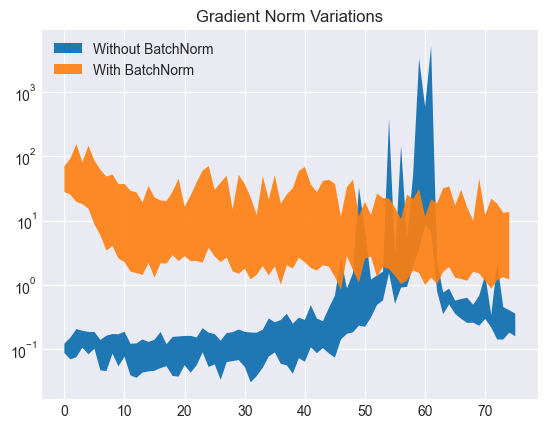

In [15]:
print(len(baseline_grad_landscape_ranges))
baseline_min_vals = [ s[0] for s in baseline_grad_landscape_ranges ]
baseline_max_vals = [ s[1] for s in baseline_grad_landscape_ranges ]
baseline_x_vals = list(range(len(baseline_min_vals)))

plt.fill_between(baseline_x_vals, baseline_min_vals, baseline_max_vals, alpha=1.0, label="Without BatchNorm")

candidate_min_vals = [ s[0] for s in candidate_grad_landscape_ranges ]
candidate_max_vals = [ s[1] for s in candidate_grad_landscape_ranges ]
candidate_x_vals = list(range(len(candidate_min_vals)))

plt.fill_between(candidate_x_vals, candidate_min_vals, candidate_max_vals, alpha=0.9, label="With BatchNorm")

#jplt.ylim(0, 250)
plt.yscale("log")
plt.legend()
plt.title("Gradient Norm Variations")
plt.show()